### <center> **Bootstrapping using GLM**
This script supports only one of the following GLM disrtibutions:
    
- Poisson
- Gamma
- Inverse Gaussian

---

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

from glm import *
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# select model distribution

while True:
    glm = input("Enter model distribution: ").title()
    if glm == "Poisson":
        distribution = sm.families.Poisson(link=sm.families.links.log()) # Log()
        break
    elif glm == "Gamma":
        distribution = sm.families.Gamma(link=sm.families.links.log()) # Log()
        break
    elif glm == "Inverse Gaussian":
        distribution = sm.families.InverseGaussian(link=sm.families.links.inverse_squared()) # InversedSquared()
        break
    else:
        print("""Ups! That is not a valid distribution :(
        Try again...""")
        pass

Enter model distribution:  GAMMA


C:\Users\tnimo\AppData\Local\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [3]:
# 0. import data
sheet_name = input("sheet name:")

X_table = import_triangle("triangles.xlsx", sheet_name, "table") # incremental observed triangle
X_triangle = import_triangle("triangles.xlsx", sheet_name, "triangle") # cumulative observed triangle

print(X_triangle)

t = X_triangle.shape[0] # number of acc./dev. years
n = int(t*(t+1)/2) # number of elements in the upper triangle
p = 2*t-1 # number of parameters to estimate

sheet name: CAS


          1          2          3         4        5
1   7017487 4151522.00  999910.00 215639.00 52760.00
2   8954484 5091234.00 1037206.00 336748.00      NaN
3   9155776 6215702.00 1086998.00       NaN      NaN
4  10394069 6190043.00        NaN       NaN      NaN
5  12755243        NaN        NaN       NaN      NaN


In [4]:
X = pd.get_dummies(X_table, columns=['dev_year', 'acc_year'], drop_first=True).iloc[:,1:] # X (design matrix w/out constant)
y = X_table['loss'] # y (target vector)

# 1. train GLM
formula = gen_formula(X)
model = sm.GLM.from_formula(formula,
                            data=pd.concat([y, X], axis=1),
                            family=distribution)
                                                           
model = model.fit()
print(model.summary(), formula, sep="\n")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   loss   No. Observations:                   15
Model:                            GLM   Df Residuals:                        6
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                        0.010660
Method:                          IRLS   Log-Likelihood:                -202.41
Date:                Wed, 23 Aug 2023   Deviance:                     0.062640
Time:                        11:03:19   Pearson chi2:                   0.0640
No. Iterations:                    12   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.7651      0.071    222.196      0.0

In [5]:
# 2. adjusted incremental (upper and lower) triangle 
m_table = gen_adj_table(model) 
m_triangle = to_triangular_form(m_table)
print(m_triangle)

# 2.1 adjusted cumulative (upper and lower) triangle (and loss reserve)
M_triangle = to_cum_triangle(m_triangle)
_, ibnr = calculate_loss(M_triangle) # IBNR by AY
R = ibnr.sum() # total IBNR

            1          2          3         4        5
1  7025480.03 4272417.02  879915.20 241459.88 52760.00
2  8851427.95 5382833.81 1108608.37 304216.18 66472.52
3  9351880.40 5687174.81 1171288.18 321416.31 70230.82
4 10286428.08 6255502.86 1288336.79 353535.94 77249.09
5 12755243.00 7756867.44 1597546.67 438387.04 95789.41


In [6]:
# 3.1 Pearson residuals
r_triangle = (X_triangle - m_triangle) / np.sqrt(m_triangle) 
residuals = r_triangle.values.flatten()
residuals = residuals[~np.isnan(residuals)] # 1D array

phi = (residuals**2).sum()/(n-p) # scale parameter

# 3.2 Adjusted pearson residuals
r_triangle = r_triangle*np.sqrt(n/(n-p)) 
aj_residuals = r_triangle.values.flatten()
aj_residuals = aj_residuals[~np.isnan(aj_residuals)] # 1D array

print(r_triangle)
print(f"\nScale parameter: {round(phi,4)}")

        1       2       3      4     5
1   -4.77  -92.48  202.26 -83.08 -0.00
2   54.77 -198.72 -107.22  93.26   NaN
3 -101.39  350.42 -123.14    NaN   NaN
4   53.07  -41.38     NaN    NaN   NaN
5   -0.00     NaN     NaN    NaN   NaN

Scale parameter: 18122.7132


In [7]:
# 4. Bootstrap loop
iterations = 10000
results = []
for i in range(iterations):
    # 4.1 bootstrap sample of the residuals (lower triangle form)
    boot_sample = pd.DataFrame(np.nan, index=range(1,t+1), columns=range(1,t+1))
    for row in boot_sample.index:
        for col in boot_sample.index:
            if row+col>t+1:
                boot_sample.loc[row,col] = np.random.choice(aj_residuals)
            else: pass

    # 4.2 lower pseudo incremental values
    mpseudo_triangle = boot_sample*np.sqrt(m_triangle)+m_triangle

    # 4.3 compute IBNR by AY
    ibnr = mpseudo_triangle.sum(axis=1)

    # 4.4 store the results and go back to step 5.1
    results.append(ibnr.sum())

results = np.array(results)

Bootstrap distribution presents the following statistics: 
	- mean: 12069081.36
	- sample size: 10000
	- standard deviation: 466616.25 
	- variance: 217730723921.31 
	- standard error: 466616.25

Quantiles: 
	- min: 10842669.21
	- 1st-Q: 11735888.43
	- median: 12012110.27
	- 3rd-Q: 12334887.06
	- max: 14114307.37



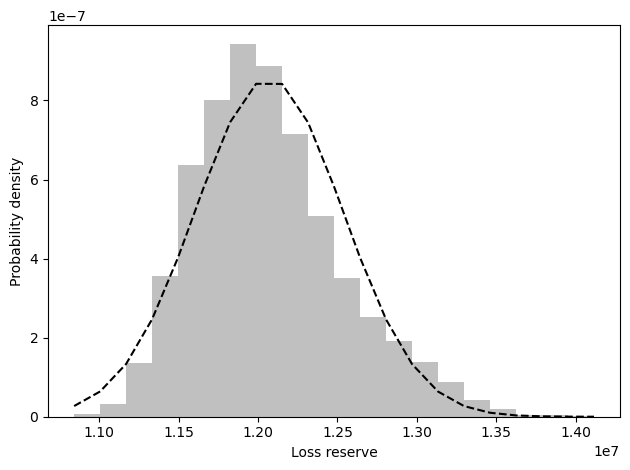

Bootstrap estimated loss reserve is 12069081.3567, with 3249.3217 bias from plain GLM (12065832.0349).

Variability measures for our estimates: 
	- process variance: 218665613843.488
	- estimation variance: 54432680.9803
	- cuadratic mean error: 218720046524.4684
	- prediction error: 467675.1506 



In [8]:
# bootstrap distribution analysis

# statistics
mean = results.mean()
std = results.std()
var = std**2
size = results.shape[0] 
se = std/np.sqrt(size)

print(f"""Bootstrap distribution presents the following statistics: 
\t- mean: {round(mean,2)}
\t- sample size: {size}
\t- standard deviation: {round(std,2)} 
\t- variance: {round(var,2)} 
\t- standard error: {round(std,2)}
""")

print(f"""Quantiles: 
\t- min: {round(results.min(),2)}
\t- 1st-Q: {round(np.quantile(results, 0.25),2)}
\t- median: {round(np.median(results),2)}
\t- 3rd-Q: {round(np.quantile(results, 0.75),2)}
\t- max: {round(results.max(),2)}
""")

# histogram
fig, ax = plt.subplots()

num_bins, mu, sigma = 20, mean, std
_, bins, patches = ax.hist(results, num_bins, density=True, color="silver") # histogram

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2)) # best normal fit

ax.plot(bins, y, '--', color="black")
ax.set_xlabel('Loss reserve')
ax.set_ylabel('Probability density')
ax.set_title(f'Histogram of IBNR: $\mu$={round(mu,2)}, $\sigma$={round(sigma,2)}')

#plt.savefig('bootGLM_hist.png')
fig.tight_layout()
plt.show()

# estimates and variability measures
bias = mean - R
print(f"Bootstrap estimated loss reserve is {round(mean,4)}, with {round(bias,4)} bias from plain GLM ({round(R,4)}).")

var_process = phi*R
var_estimations = n/(n-p)*se**2
cme = var_estimations+var_process
pe = np.sqrt(cme)

print(f"""\nVariability measures for our estimates: 
\t- process variance: {round(var_process,4)}
\t- estimation variance: {round(var_estimations,4)}
\t- cuadratic mean error: {round(cme,4)}
\t- prediction error: {round(pe,4)} 
""")

In [15]:
#pd.DataFrame(results, columns=["IBNR-glm"]).to_excel("resultados_boot_glm.xlsx", index=False)

---